In [1]:
!pip install cmasher
import cmasher as cmr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.4 MB/s eta 0:00:00


In [2]:
# Import

from __future__ import division
import os
import sys
import copy
import numpy as np
from numpy import ma
import math as m
import pandas as pd
import string

import pickle
from numpy import genfromtxt
from scipy.interpolate import griddata
from matplotlib import rc
import matplotlib.pyplot as plt
plt.style.use('default')
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.colors as colors
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

import datetime
from matplotlib.dates import DayLocator, MonthLocator, HourLocator, AutoDateLocator, DateFormatter, drange
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU, WeekdayLocator
from numpy import arange
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import NullFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.cm as cm
import matplotlib.mlab as mlab

import glob

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#%% Plot Settings

# Colors

darkblue = '#4e79a7'
orange = '#f28e2b'
red = '#e15759'
lightblue = '#76b7b2'
green = '#59a14f'
yellow = '#edc948'
purple = '#b07aa1'
pink = '#ff9da7'
brown = '#9c755f'
gray = '#bab0ac'

cbar_pad = 0.15

In [4]:
# Font / Figure Size
import matplotlib.pylab as pylab
params = {'legend.fontsize': '7',
         'axes.labelsize': '7',
         'axes.titlesize': '7',
         'xtick.labelsize': '7',
         'ytick.labelsize': '7',

         'xtick.major.pad': '7',
         'ytick.major.pad': '7',
         'axes.titlepad': 28,
         'axes.labelpad': 15,

         #'font.sans-serif':'Avenir',
          'axes.linewidth': 0.5,
         'xtick.major.width': 0.5,
         'ytick.major.width': 0.5}
pylab.rcParams.update(params)

In [5]:
def all_nonzero(arr_iter):
    """return non zero elements of all arrays as a np.array"""
    return np.concatenate([a[a != 0] for a in arr_iter])

In [6]:
# toc: total installed cost ($/kWh for energy costs, $/kW for power costs)
# fhc: fixed hourly cost ($/kWh/h for energy costs, $/kW/h for power costs)

hours_per_year = 8760 # number of hours in a year (h/yr)
crf = 0.0806 # capital recovery factor, assuming a discount rate of 7% and 30 year lifetime (%/yr)
fixed_om = 0.015 # Fixed O&M (% of capital cost)
fixed_ptilp = 0.015 # Fixed property tax, insurance, licencing, permiting (% of capital cost)

# functions to calculate fhc from toc of technologies
def get_energy_fhc(toc):
    return ((toc + fixed_om * toc) * crf) / hours_per_year

def get_energy_toc(fhc):
    return (fhc * hours_per_year) / crf / (1 + fixed_om)

def get_power_fhc(toc):
    return ((toc + fixed_ptilp * toc) * crf) / hours_per_year

def get_power_toc(fhc):
    return (fhc * hours_per_year) / crf / (1 + fixed_ptilp)

In [7]:
def reshape(data):
    # X and Y axes
    x = data['third_tech_energy_cost']
    y = data['third_tech_power_cost']

    X = list(set(x))
    X.sort()
    Y = list(set(y))
    Y.sort()

    for key in data.keys():
        if len(data[key]) > 0:
            data[key] = np.reshape(data[key], (len(Y), len(X))) ## STUPID FIX RIGHT HERE

    data['X'] = X
    data['Y'] = Y

def existence(data):
    epsilon = 10**-3
    data['pgp_exist'] = data['PGP_storage_cap'] > epsilon
    data['batt_exist'] = data['battery_cap'] > epsilon
    data['third_tech_exist'] = data['third_tech_energy_cap'] > epsilon

    # What is the number of technologies
    data['num_techs'] = sum([data['pgp_exist'], data['batt_exist'], data['third_tech_exist']])

    # Scatterplot data for if technology exists or not
    data['pgp_exist_scatter_energy'] = all_nonzero(np.multiply(data['third_tech_energy_cost'], data['pgp_exist']))
    data['pgp_exist_scatter_power'] = all_nonzero(np.multiply(data['third_tech_power_cost'], data['pgp_exist']))
    data['batt_exist_scatter_energy'] = all_nonzero(np.multiply(data['third_tech_energy_cost'], data['batt_exist']))
    data['batt_exist_scatter_power'] = all_nonzero(np.multiply(data['third_tech_power_cost'], data['batt_exist']))
    data['third_tech_exist_scatter_energy'] = all_nonzero(np.multiply(data['third_tech_energy_cost'], data['third_tech_exist']))
    data['third_tech_exist_scatter_power'] = all_nonzero(np.multiply(data['third_tech_power_cost'], data['third_tech_exist']))
    data['all_three_exist_scatter_energy'] = all_nonzero(np.multiply(data['third_tech_energy_cost'], data['num_techs'] == 3))
    data['all_three_exist_scatter_power'] = all_nonzero(np.multiply(data['third_tech_power_cost'], data['num_techs'] == 3))

def prop(data):
    PGP_dispatch = data['from_PGP_tot_dispatch']
    battery_dispatch = data['battery_tot_dispatch']
    third_tech_dispatch = data['third_tech_energy_tot_dispatch']
    tot_dispatch = sum(np.array([PGP_dispatch, battery_dispatch, third_tech_dispatch]))
    data['PGP_prop'] = np.divide(PGP_dispatch, tot_dispatch)
    data['battery_prop'] = np.divide(battery_dispatch, tot_dispatch)
    data['third_tech_prop'] = np.divide(third_tech_dispatch, tot_dispatch)
    data['dispatch_eff_num_batt'] = np.divide(1, np.square(data['PGP_prop']) + np.square(data['battery_prop']) + np.square(data['third_tech_prop']))

def storage_cost_cont(data):
    pgp = data['pgp_cost']
    batt = data['batt_cost']
    third_tech = data['third_tech_cost']
    tot_storage_tech_cost = sum(np.array([pgp, batt, third_tech]))
    data['pgp_cost_cont'] = np.divide(pgp, tot_storage_tech_cost)
    data['batt_cost_cont'] = np.divide(batt, tot_storage_tech_cost)
    data['third_tech_cost_cont'] = np.divide(third_tech, tot_storage_tech_cost)
    data['cost_eff_num_batt'] = np.divide(1, np.square(data['pgp_cost_cont']) + np.square(data['batt_cost_cont']) + np.square(data['third_tech_cost_cont']))

In [8]:
# Import Data

%cd /content/drive/MyDrive/MEM-master/Making_Figures/Mid_Duration
from extract_data_one_power import get_data_one_power

# Three tech case

path = '/content/drive/MyDrive/MEM-master/Output_Data/Mid_Duration/Param_Three_Techs_Only_Solar'
data = get_data_one_power(path, 7, 'fixed_cost', 8, 'fixed_cost', False)

data['third_tech_energy_cost'] = [get_energy_toc(i) for i in data['third_tech_energy_cost']]
data['third_tech_power_cost'] = [get_power_toc(i) for i in data['third_tech_power_cost']]

# Two tech case
two_techs_path = '/content/drive/MyDrive/MEM-master/Output_Data/Mid_Duration/Only_Solar/Li-ion_PGP_X/Li-ion_PGP'
two_techs_data = get_data_one_power(two_techs_path, 2, 'fixed_cost', 3, 'fixed_cost', False)

reshape(data)
existence(data)
prop(data)
storage_cost_cont(data)

[Errno 2] No such file or directory: '/content/drive/MyDrive/MEM-master/Making_Figures/Mid_Duration'
/content


ModuleNotFoundError: ignored

In [ ]:
# Functions for marking Li-ion and PGP energy/power-capacity total overnight costs

batt_energy_toc = 326.4
batt_power_toc = 250.92

pgp_energy_toc = 1.9992
pgp_power_toc = 1560.6

w=1
l=10

def current_PGP_current_li_ion(ax):
    energy_ticks = ax.twiny()
    energy_ticks.set_xlim(ax.get_xlim())
    energy_ticks.set_xticks([pgp_energy_toc, batt_energy_toc])
    energy_ticks.set_xticklabels([r'H$_{\rm 2}$', 'Li-ion'])
    energy_ticks.tick_params(direction='inout', length=l, width=w, pad=2.5)

    power_ticks = ax.twinx()
    power_ticks.set_ylim(ax.get_ylim())
    power_ticks.set_yticks([batt_power_toc, pgp_power_toc])
    power_ticks.set_yticklabels(['Li-ion', r'H$_{\rm 2}$'])
    power_ticks.tick_params(direction='inout', length=l, width=w, pad=2.5)

<ipython-input-19-dde550e49080>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
<ipython-input-19-dde550e49080>:31: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
<ipython-input-19-dde550e49080>:37: UserWarning: Log scale: values of z <= 0 have been masked
  cpf2 = ax2.contourf(X, Y, Z2, cmap=cost_reduction_cmap, levels=levels2, locator=ticker.LogLocator(), vmin=0.1, vmax=30)


Text(-0.55, 1.35, 'B')

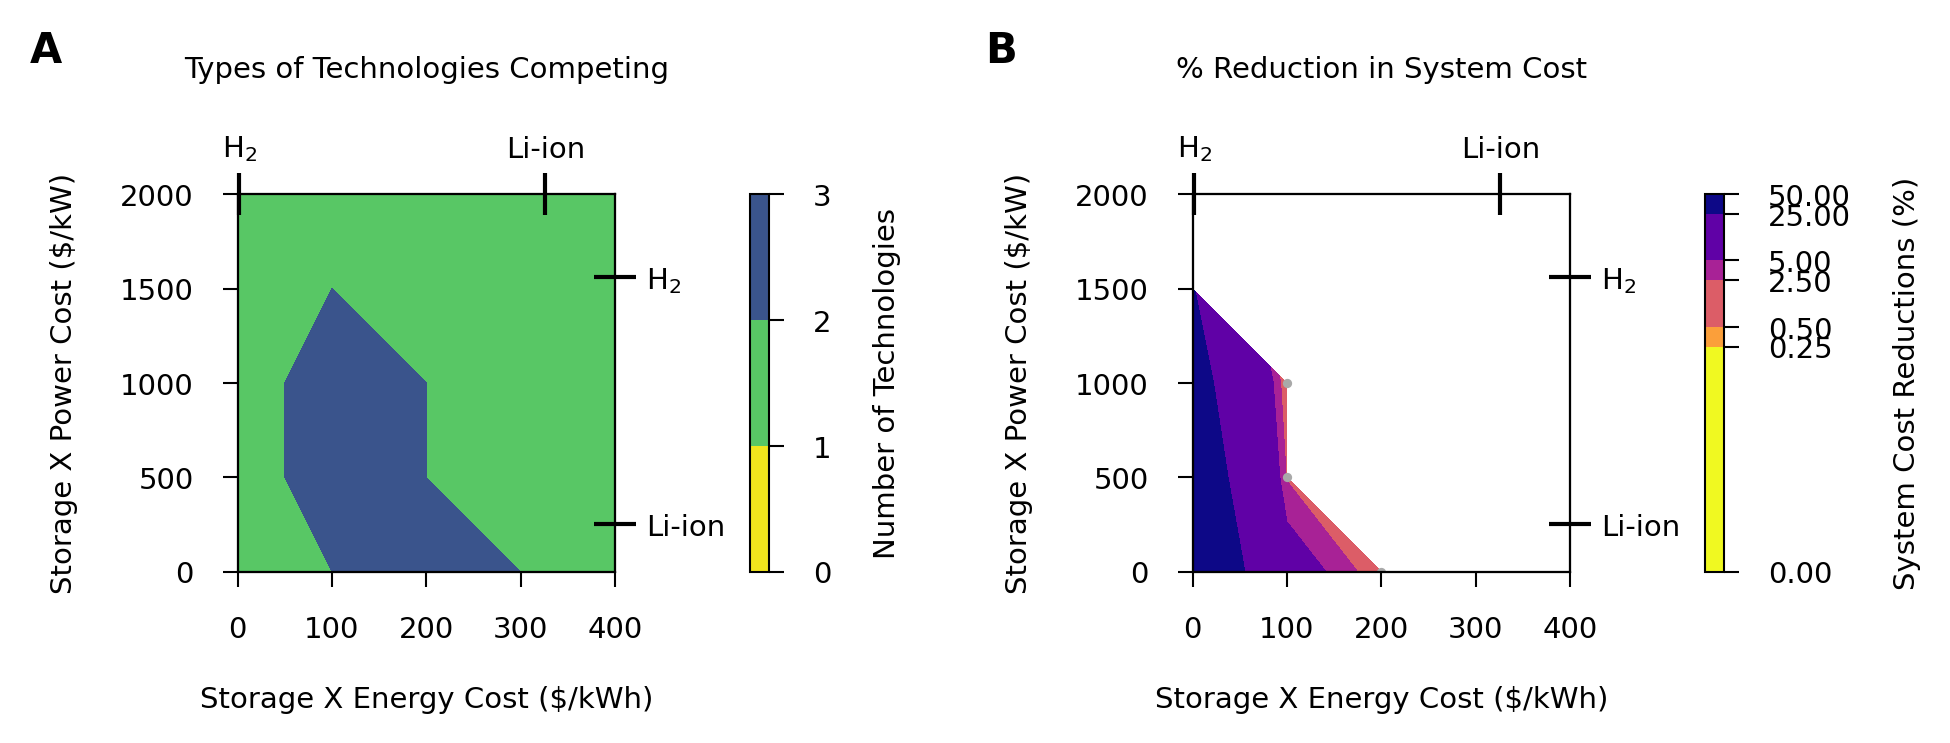

In [ ]:
mm = 1/25.4 # millimeters in inches
fig_w = 172*mm
fig_h = (172/2.8)*mm
fig = plt.subplots(nrows=1,ncols=2, figsize=(fig_w, fig_h), dpi=300)

X = data['X']
Y = data['Y']

num_techs_cmap = cmr.get_sub_cmap('viridis_r', 0.02, 0.98)
cost_reduction_cmap = 'plasma_r'

###################################################
# Figure 2a: When do 1, 2, 3, technologies exist? #
###################################################

ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax1.set_title('Types of Technologies Competing')
cbar_ylabel1 = 'Number of Technologies'

Z1 = data['num_techs']
cpf1 = ax1.contourf(X, Y, Z1, cmap=num_techs_cmap, levels=[0,1,2,3], vmin=1, vmax=3)

cbar1 = plt.colorbar(cpf1, ax=ax1, pad=0.1)
cbar1.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
cbar1.ax.set_ylabel(cbar_ylabel1, labelpad=10)

####################################################################
# Figure 2b: What is the effective number of storage technologies? #
####################################################################

ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
ax2.set_title('% Reduction in System Cost')
cbar_ylabel2 = 'System Cost Reductions (%)'

Z2 = np.abs(np.around(((data['system_cost'] - two_techs_data['system_cost'][0]) / two_techs_data['system_cost'][0])*100, 10))
levels2 = [1e-4, 0.25, 0.5, 2.5, 5, 25, 50]
cpf2 = ax2.contourf(X, Y, Z2, cmap=cost_reduction_cmap, levels=levels2, locator=ticker.LogLocator(), vmin=0.1, vmax=30)

cbar2 = plt.colorbar(cpf2, ax=ax2, pad=0.1)
cbar2.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
cbar2.ax.set_ylabel(cbar_ylabel2, labelpad=10)

# Show where 3 techs compete
dotsize=1.5
dotcolor = 'gray'
dots_indices = [i for i,j in enumerate(data['all_three_exist_scatter_energy']) if ((j>=20) or (round(j,2)==0.01))]
dots_x = [data['all_three_exist_scatter_energy'][i] for i in tuple(dots_indices)]
dots_y = [data['all_three_exist_scatter_power'][i] for i in tuple(dots_indices)]
ax2.scatter(dots_x, dots_y, c='darkgray', s=dotsize)

# Axis labels, settings
axes = [ax1, ax2]
for ax in axes:
    current_PGP_current_li_ion(ax)
    ax.set_xlim(0, 400)
    ax.set_ylim(0, 2000)
    ax.set_xlabel('Storage X Energy Cost ($/kWh)', labelpad=10)
    ax.set_ylabel('Storage X Power Cost ($/kW)', labelpad=10)
    ax.set_box_aspect(1)

# Adjust distance between subplots

plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.45)

ax1.text(-0.55, 1.35, 'A', transform=ax1.transAxes, fontsize=10, fontweight='bold')
ax2.text(-0.55, 1.35, 'B', transform=ax2.transAxes, fontsize=10, fontweight='bold')

In [ ]:
def show_data(parameter):
    pd.set_option('display.max_columns', None)
    df = pd.DataFrame(np.around(data[parameter], decimals=2))
    df = df.iloc[::-1]
    display(df)

In [ ]:
show_data(data['pgp_exist'])

TypeError: ignored

In [ ]:
df = pd.DataFrame(data['batt_exist'])
df = df.iloc[::-1]
display(df)

,0,1,2,3,4
4,True,True,True,True,True
3,False,True,True,True,True
2,False,True,True,True,True
1,False,True,True,True,True
0,False,False,True,True,True


In [ ]:
df = pd.DataFrame(data['pgp_exist'])
df = df.iloc[::-1]
display(df)

,0,1,2,3,4
4,False,True,True,True,True
3,False,True,True,True,True
2,False,True,True,True,True
1,False,True,True,True,True
0,False,True,True,True,True


In [ ]:
df = pd.DataFrame(data['third_tech_exist'])
df = df.iloc[::-1]
display(df)

,0,1,2,3,4
4,True,False,False,False,False
3,True,False,False,False,False
2,True,True,False,False,False
1,True,True,False,False,False
0,True,True,True,False,False
